# Consigna NX - Challenge.

Cada una de las filas del archivo (indexada por SK_ID_CURR) corresponde a una persona distinta que nos pidió un préstamo, y la columna "TARGET" dice qué ocurrió con ese pedido en particular (es decir, tiene un 1 si su pago se atrasó , es decir, que entraron en default, y 0 si no lo hizo). La idea es que puedas hacer un proceso que permita predecir los clientes futuros que van a entrar en default sobre el préstamo.
El archivo "HomeCredit_columns_description - HomeCredit_columns_description.parquet" tiene la información disponible sobre cada una de las columnas de los otros archivos adjuntos. 

Para poder orientarte nuestra evaluación, vamos a hacer foco en el EDA y en el modelo predictivo, sin entrar en profundidad si la métrica esta tuneada o no.

# EDA para installments_payments.parquet

In [1]:
%reset -f

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns

In [3]:
df = pd.read_parquet('data/Copia de installments_payments.parquet', engine='pyarrow')
df.head()


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [4]:
#Tamaño del dataset
df.shape

(13605401, 8)

Tengo solamente 2 tipos de datos. Ambos numéricos.

In [5]:
#conteo de cada tipo de dato
pd.value_counts(df.dtypes)

float64    5
int64      3
dtype: int64

## Estructura de datos

### Estructura de datos numericos 

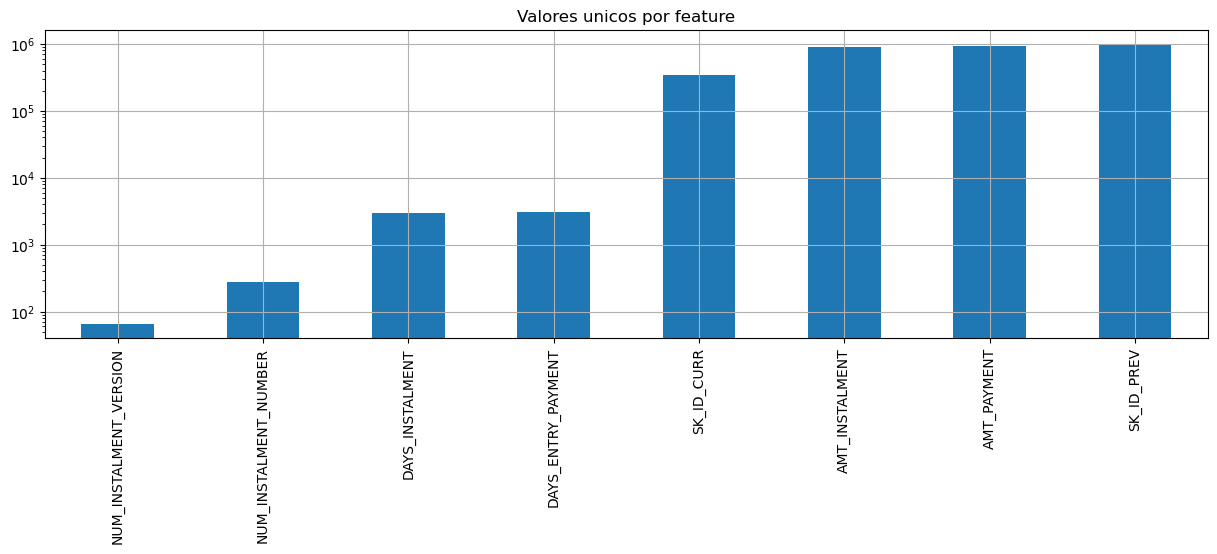

In [6]:
# Por cada feature numerico cuento la cantidad de entradas unicas

unique_values = df.select_dtypes(include="number").nunique().sort_values()

# Ploteo la informacion con el eje-y en escala log para ver los ordenes de magnitud

unique_values.plot.bar(logy=True, figsize=(15, 4), title="Valores unicos por feature")
plt.grid()
plt.show()

## Calidad de datos

### Duplicados

In [7]:
# Veo la cantidad de duplicados que tengo en el index feature

n_duplicates = df.drop(labels=["SK_ID_CURR"], axis=1).duplicated().sum()
print(f"Tenes {n_duplicates} duplicados en tu dataset.")

Tenes 0 duplicados en tu dataset.


No se encontraron filas duplicadas.

### Valores nulos

Text(0, 0.5, 'Sample Number')

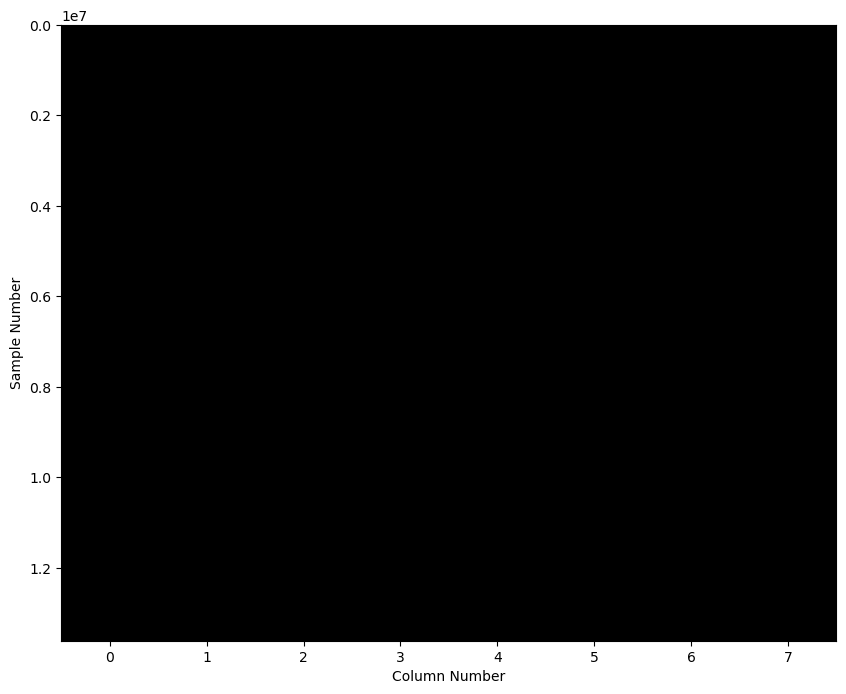

In [8]:
# Aproximacion visual de datos faltantes/nulos

plt.figure(figsize=(10, 8))
plt.imshow(df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number")

A simple viste no se ven datos faltantes

In [9]:
# Cantidad y porcentaje de valores nulos en las columnas numericas

print('cantidad de valores nulos en variables numericas')
num_nan = pd.concat([pd.DataFrame(df.select_dtypes(include='number').isna().sum(), columns=['q_nan']),pd.DataFrame(df.select_dtypes(include='number').isna().sum()/len(df.select_dtypes(include='number'))*100, columns=['perc_nan'])], axis=1)
print(num_nan.to_markdown())

cantidad de valores nulos en variables numericas
|                        |   q_nan |   perc_nan |
|:-----------------------|--------:|-----------:|
| SK_ID_PREV             |       0 |  0         |
| SK_ID_CURR             |       0 |  0         |
| NUM_INSTALMENT_VERSION |       0 |  0         |
| NUM_INSTALMENT_NUMBER  |       0 |  0         |
| DAYS_INSTALMENT        |       0 |  0         |
| DAYS_ENTRY_PAYMENT     |    2905 |  0.0213518 |
| AMT_INSTALMENT         |       0 |  0         |
| AMT_PAYMENT            |    2905 |  0.0213518 |


In [10]:
# Columnas que tienen un porcentaje de datos nulos mayor al 20% (criterio de corte)

num_nan_pos = num_nan[num_nan['perc_nan']>=20]

Tomo 20% de tolerancia para los datos faltantes. Si es posible, se deberían pedir los datos para poder rellenar los datos faltantes.

In [11]:
# imprimo en pantalla las columnas con gran porcetanje de datos nulos.

print(num_nan_pos.to_markdown())

| q_nan   | perc_nan   |
|---------|------------|


In [12]:
# lista de columnas a dropear por gran cantidad de valores faltantes (mayor al 20%)

col_to_drop = list(num_nan_pos.index)

Dropeo dichas columnas en este momento para que no estorben al momento de graficar las variables.

In [13]:
df.drop(columns=col_to_drop, inplace=True)
df.reset_index(drop=True)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [14]:
#separo los nombres de las columnas en los diferentes tipos de dato

numerical_columns = [x for x in df.columns if df[x].dtype != 'object' and df[x].dtype != 'bool']
cat_columns = [x for x in df.columns if x not in numerical_columns]
int_columns = [x for x in numerical_columns if df[x].dtypes != 'float64']
float_columns = [x for x in numerical_columns if x not in int_columns]

print('cat:',len(cat_columns),'int:', len(int_columns),'float:', len(float_columns))

cat: 0 int: 3 float: 5


### Variables numericas

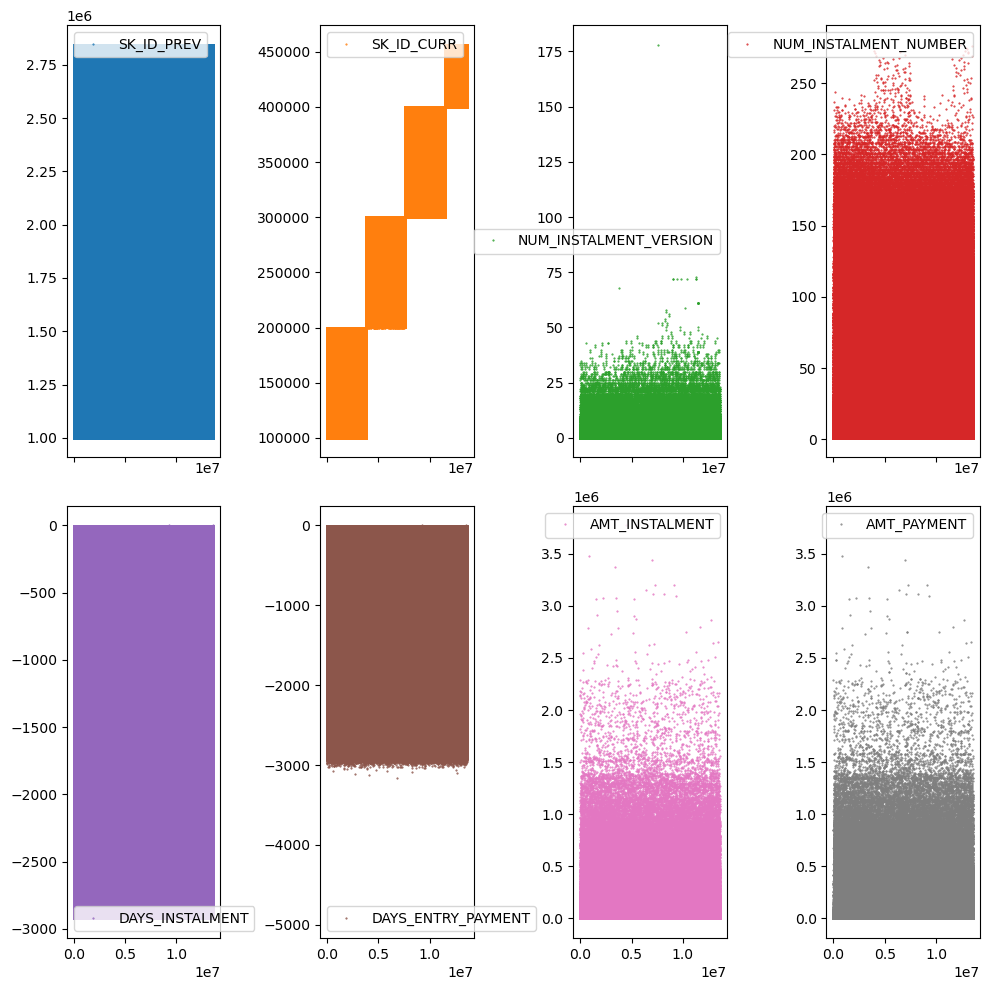

In [15]:
# Me fijo como son los datos en el dataset. esto me ayuda a detectar los datos faltantes.  

df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),figsize=(10, 10), markersize=1)
plt.tight_layout()

#### variables enteras/discretas

In [21]:
df[int_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,13605401.0,1.903365e+06,536202.905546,1000001.0,1434191.0,1896520.0,2369094.0,2843499.0
SK_ID_CURR,13605401.0,2.784449e+05,102718.310411,100001.0,189639.0,278685.0,367530.0,456255.0
NUM_INSTALMENT_NUMBER,13605401.0,1.887090e+01,26.664067,1.0,4.0,8.0,19.0,277.0


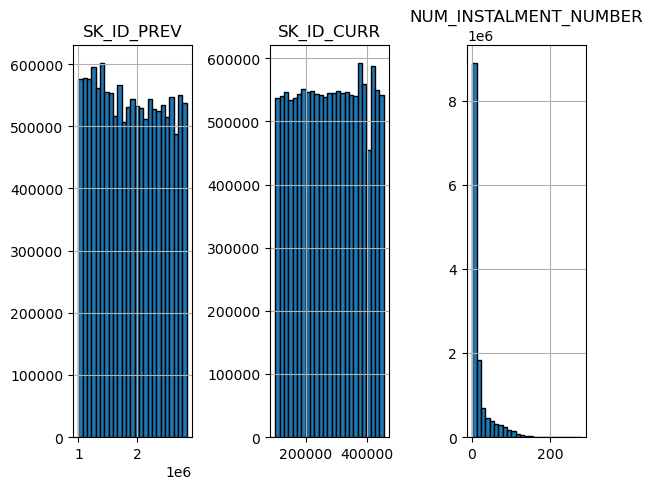

In [23]:
# cantidad de bins que debería tener mi histograma. Utilizo el criterio de Sturge.

n_bins = round(1 + 3.322 * np.log10(len(df)))

# Ploteo histogramas de las variables dtype=int64

df[[x for x in int_columns if x != 'TARGET']].hist(bins=n_bins, figsize=(10, 5), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

#### variables continuas

In [18]:
df[float_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
NUM_INSTALMENT_VERSION,13605401.0,0.856637,1.035216,0.0,0.000,1.000,1.000,178.000
DAYS_INSTALMENT,13605401.0,-1042.269992,800.946284,-2922.0,-1654.000,-818.000,-361.000,-1.000
DAYS_ENTRY_PAYMENT,13602496.0,-1051.113684,800.585883,-4921.0,-1662.000,-827.000,-370.000,-1.000
AMT_INSTALMENT,13605401.0,17050.906989,50570.254429,0.0,4226.085,8884.080,16710.210,3771487.845
AMT_PAYMENT,13602496.0,17238.223250,54735.783981,0.0,3398.265,8125.515,16108.425,3771487.845


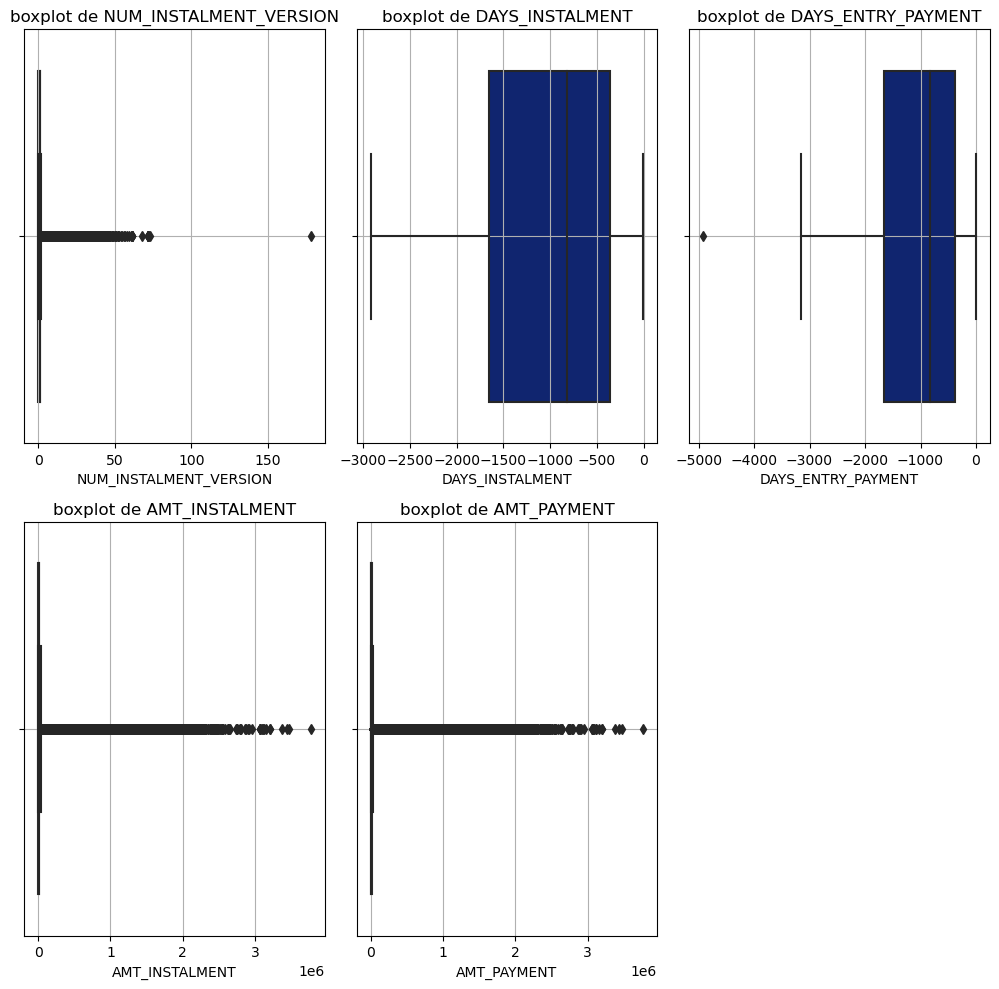

In [24]:
# veo las distribuciones de las varaibles con dtype=float64

plt.figure(figsize=(10,10))
for index, column in enumerate([x for x in float_columns]):
  plt.subplot(ceil(len(float_columns)/3), 3, index+1)
  sns.boxplot(data=df, x=df[column], palette='dark')
  plt.title('boxplot de {}'.format(column))
  plt.grid()  
  plt.tight_layout()

In [25]:
# me armo el percentil 99% para las diferentes variables que parecen tener outliers.

outliers_detection = float_columns
outlier_treshold = pd.DataFrame(df.describe(percentiles=[0.99]).loc['99%']).T
outlier_treshold[outliers_detection]

,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
99%,4.0,-21.0,-28.0,146068.695,178003.95975


In [26]:
# me fijo la cantidad de valores que pasan el treshold del percentil 99.5%. Estos son los cantidatos a ser eliminados.

for outlier in outliers_detection:
    print(outlier,
    ':',
    pd.DataFrame(df[abs(df[outlier]) > abs(outlier_treshold[outlier].loc['99%'])][outlier]).shape[0], 
    '(',
    pd.DataFrame(df[abs(df[outlier]) > abs(outlier_treshold[outlier].loc['99%'])][outlier]).shape[0]/len(df[outlier])*100 ,
    '%)')


NUM_INSTALMENT_VERSION : 125279 ( 0.9208034368116016 %)
DAYS_INSTALMENT : 13467024 ( 98.98292597182545 %)
DAYS_ENTRY_PAYMENT : 13463547 ( 98.95736994448013 %)
AMT_INSTALMENT : 136054 ( 0.9999999264997776 %)
AMT_PAYMENT : 136025 ( 0.9997867758546771 %)


In [35]:
# me fijo la relación entre las familias con mas de diez integrantes y la cantidad de hijos e hijas que tienen.

df[df['NUM_INSTALMENT_VERSION'] >= 150]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
7580806,1488056,276526,178.0,2,-150.0,NaN,347349.6,NaN


In [37]:
# me fijo la relación entre las variables de cantidad de personas en default en el entorno del cliente. (Después se observa que hay gran correlacion entre OBS_60 y OBS_30)

df[df['DAYS_ENTRY_PAYMENT']<-4000]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
11943247,1752167,447329,3.0,7,-1732.0,-4921.0,11401.335,11401.335


Este parece ser un outlier. Porque es el único valor tan alto que existe.

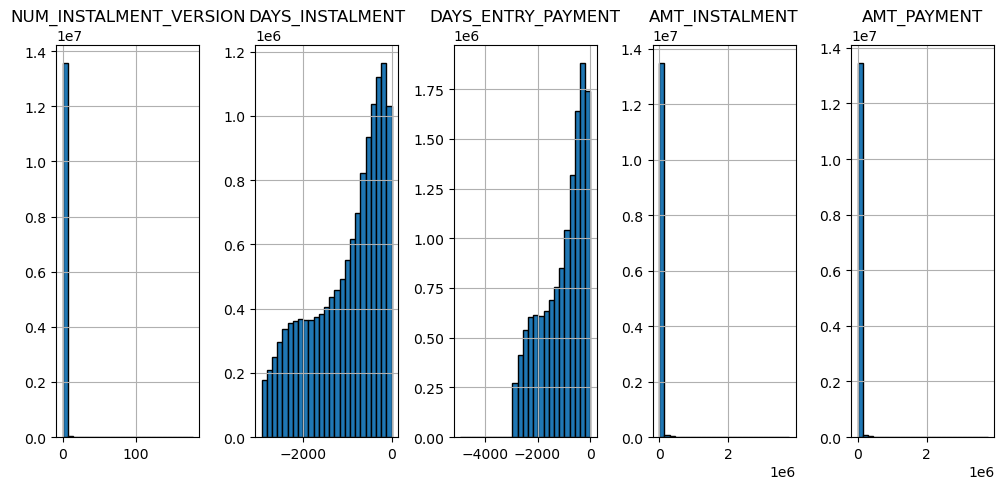

In [40]:
# ploteos de las variables con dtype=float64
n_bins = round(1 + 3.322 * np.log10(len(df)))
df[float_columns].hist(bins=n_bins, figsize=(10, 5), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

### tabla de correlaciones

<AxesSubplot: >

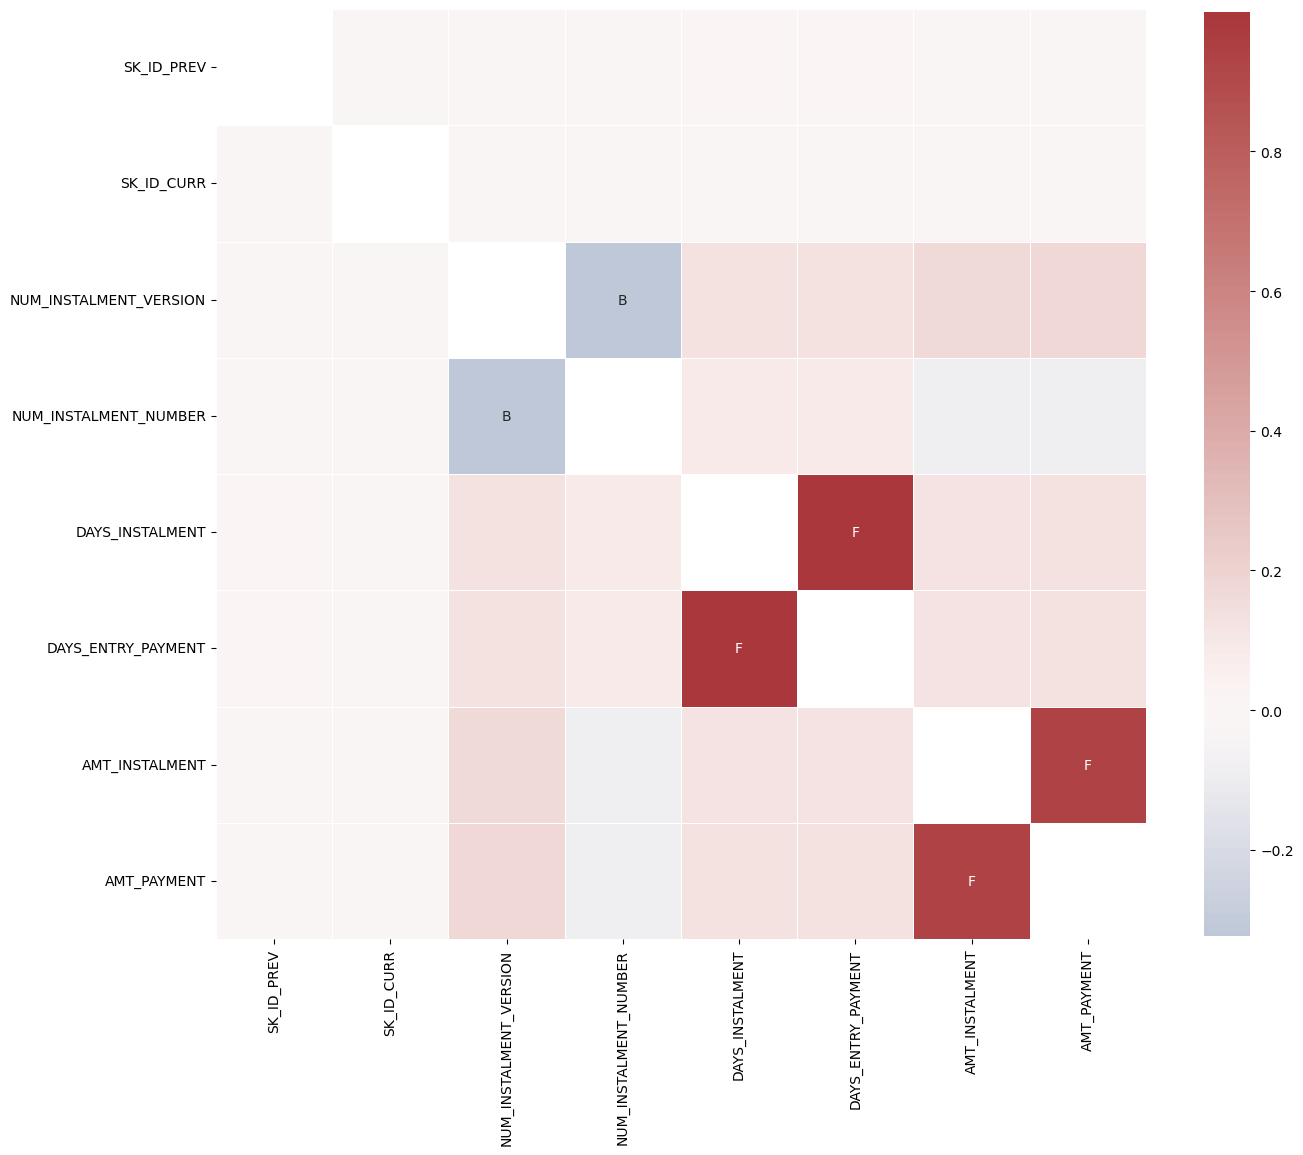

In [41]:
# calculo las correlaciones entre las variables numericas
corr = df.corr()

# creo labels para las correlaciones
labels = np.where(np.abs(corr)>0.75, "F",
                  np.where(np.abs(corr)>0.5, "M",
                  np.where(np.abs(corr)>0.25, "B", "")))

# ploteo correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr, mask=np.eye(len(corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

In [42]:
#  Creates a mask to remove the diagonal and the upper triangle.
lower_triangle_mask = np.tril(np.ones(corr.shape), k=-1).astype("bool")

#  Stack all correlations, after applying the mask
corr_stacked = corr.where(lower_triangle_mask).stack().sort_values()

#  Showing the lowest and highest correlations in the correlation matrix
display(corr_stacked)

NUM_INSTALMENT_NUMBER   NUM_INSTALMENT_VERSION   -0.323414
AMT_INSTALMENT          NUM_INSTALMENT_NUMBER    -0.089640
AMT_PAYMENT             NUM_INSTALMENT_NUMBER    -0.087664
NUM_INSTALMENT_NUMBER   SK_ID_PREV               -0.002095
                        SK_ID_CURR               -0.000548
AMT_INSTALMENT          SK_ID_CURR               -0.000226
AMT_PAYMENT             SK_ID_CURR               -0.000124
NUM_INSTALMENT_VERSION  SK_ID_CURR                0.000480
                        SK_ID_PREV                0.000685
DAYS_INSTALMENT         SK_ID_CURR                0.001191
DAYS_ENTRY_PAYMENT      SK_ID_CURR                0.001215
AMT_PAYMENT             SK_ID_PREV                0.001887
AMT_INSTALMENT          SK_ID_PREV                0.002042
SK_ID_CURR              SK_ID_PREV                0.002132
DAYS_ENTRY_PAYMENT      SK_ID_PREV                0.003734
DAYS_INSTALMENT         SK_ID_PREV                0.003748
                        NUM_INSTALMENT_NUMBER     0.0902

## Conclusiones

- Necesito agrupar la data por el SK_ID_CURR para poder hacer un join con la información que tengo en las otras tablas. (PK SK_ID_CURR)

- Hay alunas variables que voy a descartar por no poder tomar una función agregada en las mismas. SK_ID_PREV, NUM_INSTALMENTE_VERSION.

- Tengo que rellenar los datos faltantes en el dataset.

- Tratar los outliers que poseo en algunas de las features (por ejemplo: NUM_INSTALMENT_VERSION, DAYS_ENTRY_PAYMENT)

- Eliminar aquellas variables que tengan alta correlacion con otra. Utilizar un criterio para quedarte con una de las dos implicadas. 

- Puedo crear una variable que me de la taza pagada del antiguo instalment: AMT_PAYMENT/AMT_INSTALMENT, con esto me borro la correlacion entre ambas variables. Lo mismo puede hacerse con DAYS_ENTRY_PAYMENT/DAYS_INSTALMENT



# Pre - preparación de datos

In [85]:
# elimino el outlier que encontramos

df_wo_outliers = df.drop([df[df['DAYS_ENTRY_PAYMENT'] < -4000].index[0]], axis=0)

In [86]:
# me creo los nuevos features

df_wo_outliers['AMT_PAYMENT_INSTALMENT'] = df_wo_outliers['AMT_PAYMENT'] / df_wo_outliers['AMT_INSTALMENT']
df_wo_outliers['DAYS_ENTRY_INSTALMENT'] = df_wo_outliers['DAYS_ENTRY_PAYMENT'] / df_wo_outliers['DAYS_INSTALMENT']

df_new_features = df_wo_outliers[['SK_ID_CURR','AMT_PAYMENT_INSTALMENT','DAYS_ENTRY_INSTALMENT']].copy()

In [87]:
# me genero el dataset final para unir a los otros.

df_grouped = df_new_features.groupby(by=['SK_ID_CURR']).mean()
df_grouped.reset_index(inplace=True)

In [88]:
df_grouped

,SK_ID_CURR,AMT_PAYMENT_INSTALMENT,DAYS_ENTRY_INSTALMENT
0,100001,1.000000,1.004767
1,100002,1.000000,1.131260
2,100003,1.000000,1.007302
3,100004,1.000000,1.010037
4,100005,1.000000,1.039191
...,...,...,...
339582,456251,1.000000,1.357098
339583,456252,1.000000,1.001208
339584,456253,0.928571,1.007221
339585,456254,1.000000,1.293806


<AxesSubplot: >

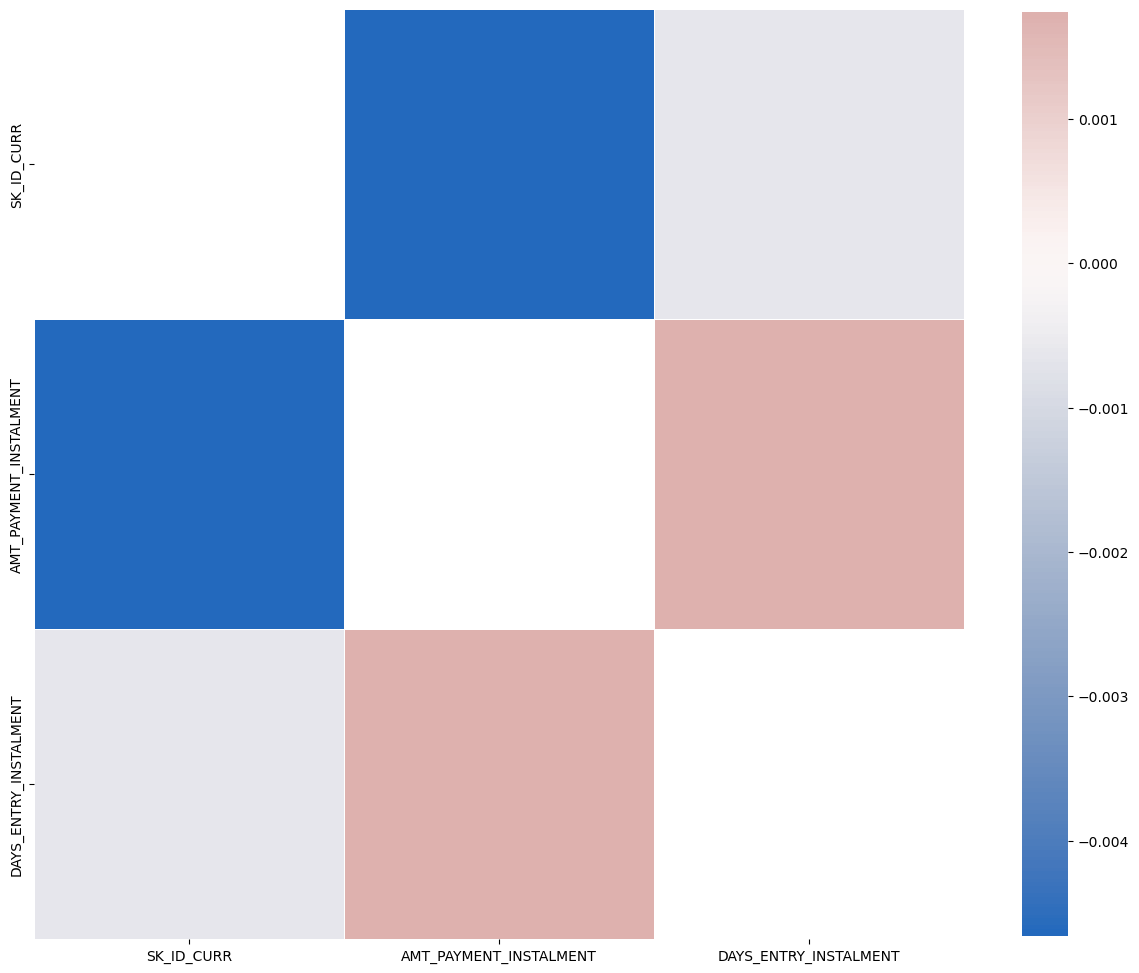

In [89]:
corr_grouped = df_grouped.corr()

# creo labels para las correlaciones
labels = np.where(np.abs(corr_grouped)>0.75, "F",
                  np.where(np.abs(corr_grouped)>0.5, "M",
                  np.where(np.abs(corr_grouped)>0.25, "B", "")))

# ploteo correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_grouped, mask=np.eye(len(corr_grouped)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

In [90]:
df_grouped.to_csv('outputs/preprocessed_instalment.csv')